In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
from cv_proj_imports import *
from cv_proj_consts import *

/home/crazy_slime/anaconda3/envs/fastai/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


# Preprocessing

We want to clean and fix our training and test data, before we run algorithms on it.

Many concepts taken from the following notebook but fully reimplmented by me
https://www.kaggle.com/martinpiotte/whale-recognition-model-with-score-0-78563

In [3]:
train_image_files = L(sorted(get_image_files(train_data_dir)))
test_image_files = L(sorted(get_image_files(test_data_dir)))
all_image_files = L(sorted(train_image_files + test_image_files))

## Invalid Image Removal

I explored (manually by viewing images, and by reading forum posts) the issue of invalid images. It seems there are a few invalid images in the dataset.

However, at this point, I decided to put effort into other larger data cleaning steps (see below).

So I *will not* handle this data problem.

## Wrong Labels

Some people in Kaggle challenge discussion board found that some labels are incorrect:
    
- [Incorrect train labels](https://www.kaggle.com/c/humpback-whale-identification/discussion/80170)

However there was no method or result published, and the problem doesn't seem so big (like the duplicates which we handled earlier)

So I *will not* handle this data problem.

## Duplicate Image Identification

From
- https://www.kaggle.com/martinpiotte/whale-recognition-model-with-score-0-78563
- [106 pairs of duplicates (affects over 1000 images!) - Vladislav Shakhray](https://www.kaggle.com/c/humpback-whale-identification/discussion/82557#latest-482085)
- [List of duplicate whale IDs - Alex Mokin](https://www.kaggle.com/c/humpback-whale-identification/discussion/81885#latest-480242)

In [4]:
# make ImageHash sortable
from imagehash import ImageHash
def __ImageHash__lt__(self, other): return (self - other) > 0
setattr(ImageHash, '__lt__', __ImageHash__lt__)

In [5]:
_all_images_phash_csv_fn = 'all_images_phash.csv'
try:    
    all_images_phash_df = pd.read_csv(_all_images_phash_csv_fn, header=None, sep='\t')
    all_images_phash = {row[0]:row[1] for index, row in all_images_phash_df.iterrows()}
    assert len(all_image_files) == len(all_images_phash), "Read bad file - aborting"
    print("Loaded all_images_phash from CSV")
except FileNotFoundError:
    all_images_phash = {img.name: str(imagehash.phash(Image.open(img))) for img in tqdm(all_image_files)}
    all_images_phash_df = pd.DataFrame.from_dict(data=all_images_phash, orient='index')
    all_images_phash_df.to_csv(_all_images_phash_csv_fn, header=False, sep='\t')
    print("Wrote all_images_phash to CSV")

Loaded all_images_phash from CSV


**Note: eventually didn't implement removing duplicates from the input**

## Background Removal, Crop and Center, Color

We want our classifier to only look at the whale tail, and not on surrounding water.

During the competition, people used a segmentation algorithm, manually annotated on some images, and then applied on the rest.

However, after the competition ended, there was a paper submitted to CVPR 2019 called [BASNet - Boundary-Aware Salient Object Detection](https://github.com/NathanUA/BASNet)

It finds the main ("salient") object, and creates a mask, where only this object is shown.

![BASNet Architecture](https://raw.githubusercontent.com/NathanUA/BASNet/master/figures/architecture.png)

I ran the code from BASNet GitHub in commandline (only adjusting the paths) to create 'train_mask' and 'test_mask' folders, with the masks of the original images. The filenames are the same, and extension is PNG instead of JPG.

There were also uses of object detection algorithms to crop the whale images:
- https://www.kaggle.com/ashishpatel26/comprehensive-guide-of-object-detection-algorithms
- https://www.kaggle.com/phhasian0710/create-bounding-box-images-whale-recognition

However, I used OpenCV's [findContours](https://docs.opencv.org/3.4/d4/d73/tutorial_py_contours_begin.html) on the *mask* to to find the contour of the whale, and it worked quite well.

Finally, I made the images grayscale, as recommended by some on the Kaggle forum, since we're looking at the shape and not color.

Next I'll create the images after this processing:
1. with the mask from BASNet applied
2. automatic contrast
3. grayscale

In [ ]:
def show_masked_image(img_name, is_train=True, display_stages=True, save_result=False):
    if is_train:
        img_path = train_data_dir/'{}.jpg'.format(img_name)
        mask_path = data_dir/'train_mask'/'{}.png'.format(img_name)
        result_cropped_path = data_dir/'train_cropped'/'{}.jpg'.format(img_name)
        result_processed_path = data_dir/'train_processed'/'{}.jpg'.format(img_name)
    else:
        img_path = test_data_dir/'{}.jpg'.format(img_name)
        mask_path = data_dir/'test_mask'/'{}.png'.format(img_name)
        result_cropped_path = data_dir/'test_cropped'/'{}.jpg'.format(img_name)
        result_processed_path = data_dir/'test_processed'/'{}.jpg'.format(img_name)
    
    source_image = Image.open(img_path).convert('RGB')
    blend_background = Image.new(mode='RGB', size=source_image.size, color=(128, 128, 128))
    mask = Image.open(mask_path).convert('L')
    image_masked = Image.composite(source_image, blend_background, mask)
    
    image_masked_np = np.array(image_masked)
    mask_np = np.array(mask)
    contours, hierarchy = cv2.findContours(mask_np,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]
        
    roi = None
    maxcntsz = 0
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        if w < 32 or h < 32: continue # skip tiny irrelevant rects
            
        # take the contour with max size
        cntsz = w*h
        if cntsz > maxcntsz:
            maxcntsz = cntsz
            roi=image_masked_np[y:y+h,x:x+w]
        
        if display_stages:
            cv2.rectangle(mask_np,(x,y),(x+w,y+h),(200,0,0),2) # draw rect
    
    if roi is None:
        # nothing found, save original image
        result = source_image
    else:
        result = Image.fromarray(roi).resize((224,224))    
            
    if display_stages:
        # note: latest code (which plotted following cells) lost by mistake
        display(source_image.resize((224,224)))    
        display(result.resize((224,224)))        
        display(Image.fromarray(mask_np).resize((224,224)))
        display(result)
    
    if save_result:
        result.save(result_path)

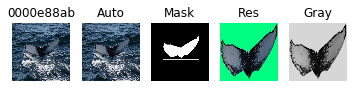

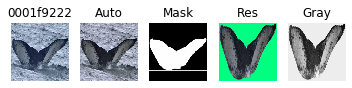

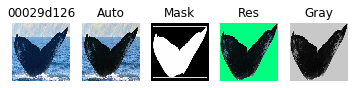

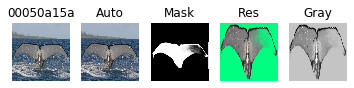

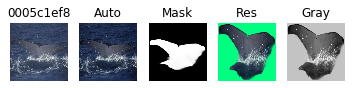

In [112]:
for i,image_fn in zip(range(len(train_image_files)),tqdm(train_image_files)):
    show_masked_image(image_fn, is_train=True, display_stages=(i<5), save_result=False)

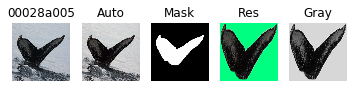

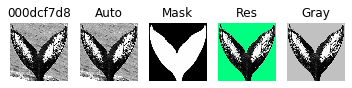

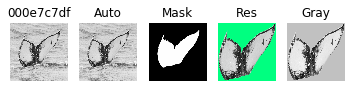

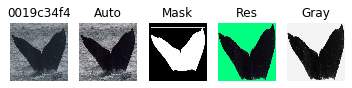

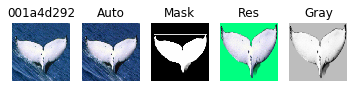

In [113]:
for i,image_fn in zip(range(len(test_image_files)),tqdm(test_image_files)):
    show_masked_image(image_fn, is_train=False, display_stages=(i<5), save_result=True)